# Survival Analysis

This is a detailed guide for using DNAMite for survival analysis.

### What is Survival Analysis?

In survival analysis, the goal is to predict the *survival probability* $P(T > t)$, or equivalently the *cumulative incidence function* (CIF) $P(T \leq t)$ for some time-to-event random variable $T$. Survival analysis is somewhat similar to binary classification, but instead of predicting a single probability (e.g. $P(T > t)$ for a single $t > 0$), we want to estimate the entire distribution, i.e. the survival probability at all times $t \in \mathbb{R}$. Survival analysis is very common in healthcare (e.g. when $T$ is mortality time or time-until-diagnosis), but appears in many domains such as customer churn, engineering, and actuarial science. 

In survival analysis models, we are usually given a set of features $X$ and asked to estimate the conditional distribution $T \mid X$, for example by estimating the conditional CIF $P(T \leq t \mid X)$. Survival analysis problems are also often complicated by *censoring* of some samples. When a dataset encounters censoring, a. second time-to-event random variable $C$ denotes the censoring time of patients, and we only are given the following two random variables:

1) $Z = \text{min}(T, C)$: the observed event time.
2) $\delta = \mathcal{1}_{C > T}$: the indicator if the sample is censored (0) or not (1).

Thus, we observe data of the form $(X_i, Z_i, \delta_i), i= 1, 2, \ldots, n$ and from this data we would like to estimate $P(T \leq t \mid X)$. 

### dnamite for Survival Analysis

For an overview of the methodology used to fit a dnamite model in general, see the [Why dnamite User Guide](https://dnamite.readthedocs.io/en/latest/notebooks/user_guides/why_dnamite.html).

A dnamite survival analysis model outputs $K$ predictions $\hat{P}(T \leq t_1 \mid X), \ldots, \hat{P}(T \leq t_K \mid X)$ corresponding to $K$ evaluation times $t_1, \ldots, t_K$. These predictions are optimized using the Inverse Probability of Censoring Weighting (IPCW) loss: $$ \sum_{i=1}^n \sum_{k=1}^K \frac{1_{Z_i > t_k} \hat{P}(T \leq t_k \mid X)^2}{\hat{P}(C > t_k)} + \frac{1_{Z_i \leq t_k, \delta_i = 1} (1 - \hat{P}(T \leq t_k \mid X))^2}{\hat{P}(C > Z_i)}. $$ Let's break down this loss a little bit: 

- The indicator in the first term $1_{Z_i > t_k}$ only is 1 when the observed event time is greater than $t_k$. When $Z_i > t_k$ we also know that $T_i > t_k$ by definition, so it makes sense to minimize $\hat{P}(T \leq t_k \mid X)$ in these cases. 
- On the other hand, the indicator in the second term $1_{Z_i \leq t_k, \delta_i = 1}$ is 1 only when the true event is known to have occurred before time $t_k$. In these cases, it makes sense to maximize $\hat{P}(T \leq t_k \mid X)$.
- The denominator terms use an estimate for the survival function of the censoring time $C$. dnamite obtains this estimate by fitting a Kaplan-Meier model to the censoring distribution before the start of model training.

By producing time-dependent predictions, dnamite differs from many survival analysis models that produce time-independent risk scores trained using the Cox loss. This allows dnamite to more accurately capture the entire time-to-event distribution. 

### Training a dnamite Survival Model

dnamite follows the conventions used in [scikit-survival](https://scikit-survival.readthedocs.io/en/stable/index.html) for preparing survival analysis data. Survival labels should be stored in a numpy structured array with dype `np.dtype([('event', bool), ('time', float)])`, where `event` is True only when the sample is not censored and `time` is the event/censor time.

For this guide we will use the SUPPORT dataset [1], a standard dataset for survival analysis. The support dataset estimates the mortality risk of critically ill hospital patients. We will pull the data from the [UCI repository](https://archive.ics.uci.edu/dataset/880/support2) where more dataset details can be found.

[1] Knaus, William A., et al. "The SUPPORT prognostic model: Objective estimates of survival for seriously ill hospitalized adults." Annals of internal medicine 122.3 (1995): 191-203.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from ucimlrepo import fetch_ucirepo 
  
support2 = fetch_ucirepo(id=880) 
X = support2.data.features 
y = np.array(
    list(zip(
        support2.data.original["death"], 
        support2.data.original["d.time"]
    )), 
    dtype=[('event', 'bool'), ('time', 'float32')]
)

print("Percent of samples that are censored: ", np.mean(~y['event']))

Percent of samples that are censored:  0.3189456342668863


We see that roughly 30\% of samples in the dataset are censored, which means that roughly 30\% of patients in the dataset do not die before the end of data collection.

Fitting a dnamite survival model is then the same as fitting a regression of classification model.

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

import torch 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from dnamite.models import DNAMiteSurvival
model = DNAMiteSurvival(device=device)
model.fit(X_train, y_train)

### Evaluating Survival Models

The most common metric for evaluating survival analysis models is concordance index or C-index, which is similar to AUC but robust to censoring. The C-index is defined as:

$$
\frac{\sum_{i, j} 1(Z_i < Z_j) \cdot 1(r_i > r_j)}{\sum_{i, j} 1(t_i < t_j)}
$$

where $r_i$ is the predicted risk score for sample $i$. From this definition it is evident that C-index only takes as input a single risk score for each sample. This is natural for models like Cox regression that output a single risk score, but for models like DNAMite that output time-dependent risk scores C-index is not an appropriate metric. Thus, we recommend evaluating DNAMite using the [time-dependent AUC](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.metrics.cumulative_dynamic_auc.html) metric implemented in scikit-survival. The [scikit-survival evaluation guide](https://scikit-survival.readthedocs.io/en/stable/user_guide/evaluating-survival-models.html) is a great resource for learning more about different survival analysis metrics. 

In [5]:
from sksurv.metrics import cumulative_dynamic_auc

test_times = np.linspace(30, 365*4, 100)
cdf_preds = 1 - model.predict_survival(X_test, test_times=test_times)
_, mean_auc = cumulative_dynamic_auc(y_train, y_test, cdf_preds, test_times)
mean_auc

0.9067431780318808

### Time-dependent Interpretations

Since DNAMite outputs time-dependent predictions, we can look at model interpretations at a specific evaluation point. For example, we can look at the feature importances for predicting mortality risk in the next year.

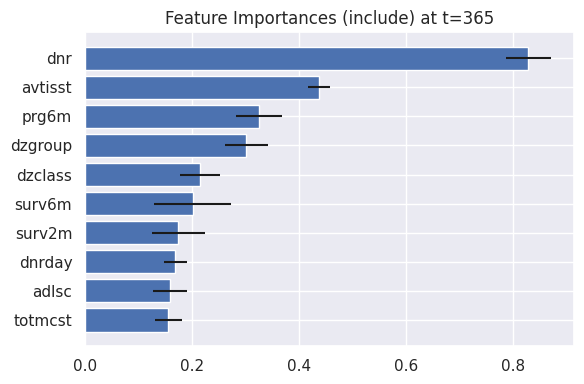

In [6]:
model.plot_feature_importances(eval_times=365)

Similarly we can look at some shape functions related to mortality risk in the next year.

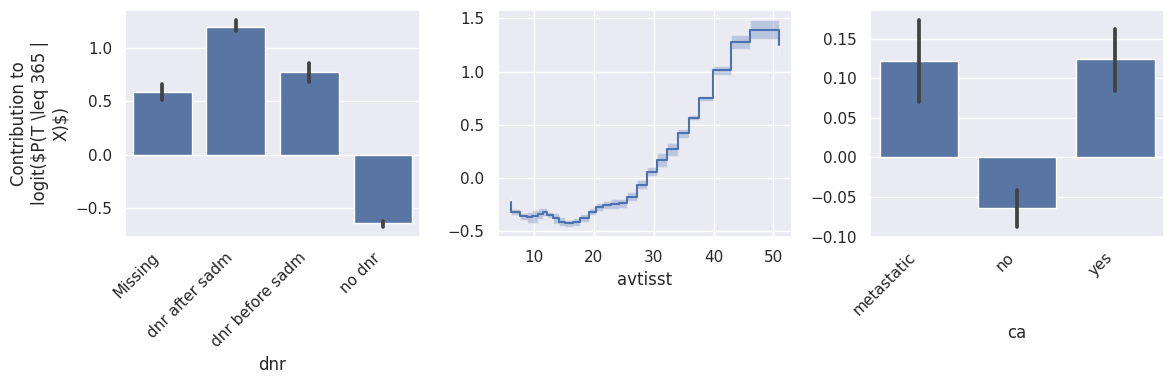

In [7]:
model.plot_shape_function(feature_names=["dnr", "avtisst", "ca"], eval_times=365)

Let's look at each of these features to see if the resulting shape functions makes sense:
- **dnr**: this feature indicates if the patients has a do not resuscitate order or not. It makes sense that patients are at higher risk of imminent mortality risk if they have dnr orders.
- **avtisst**: this feature indicates the average TISS score, where higher TISS scores indicate higher intensity care in the ICU. It's again natural that patients receiving higher intensity care are at higher mortality risk.
- **ca**: this feature indicates if the patient has local cancer (yes), cancer that has spread (metastatic), or does not have cancer at all (no). It's well known that metastatic cancer prevents higher mortality risk, which is reflected in the learned shape function.

How would the results change with a different evaluation time? Let's look at the feature importances and some shape functions for mortality risk in the next 30 days instead of in the next year.

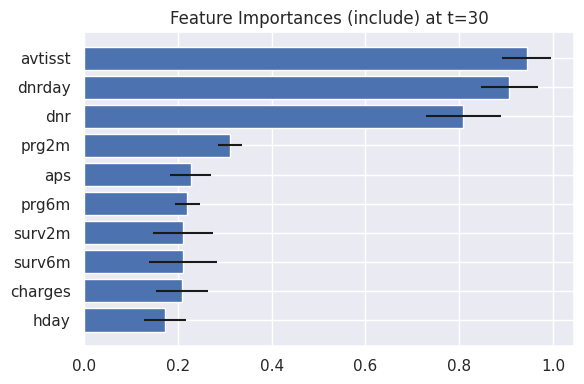

In [8]:
model.plot_feature_importances(eval_times=30)

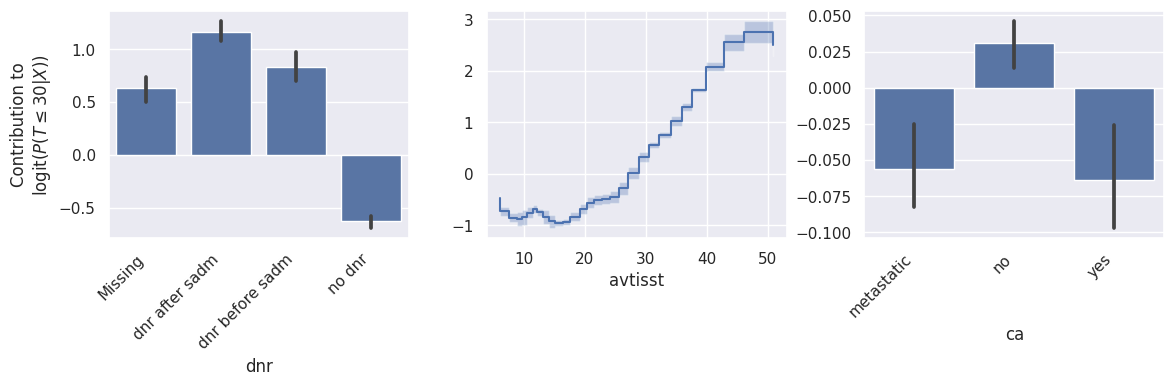

In [9]:
model.plot_shape_function(feature_names=["dnr", "avtisst", "ca"], eval_times=30)

Interestingly, avtisst becomes more important than dnr for 30-day mortality. One explanation is that increased TISS scores can indicate very immediate mortality risk (e.g. increased mechanical ventilation, monitoring), while a do not resuscitate order do not imply as immediate mortality risk. Otherwise, the shape of the shape functions remain very similar.

### Calibration

It's important that the survival/CIF estimates from a survival analysis model are calibrated. A survival analysis model is calibrated if 
for all $t > 0$ and all sets $S = \{i \,:\, \hat{P}(T \leq t \mid X^{(i)}) \approx \alpha\}$ we have
$$
\alpha \approx \hat{P}(T \leq t \mid X^{(i)})
\approx \sum_{i\in S} \frac{1_{T^{(i)} \leq t}}{|S|}.
$$
That is, when the model predicts $\hat{P}(T \leq t \mid X^{(i)})$, this prediction can be interpreted in the correct probabilistic sense. There are multiple ways to check calibration for a survival analysis model, but we recommend assessing calibration via visual inspection of calibration plots as described in [1]. DNAMite can easily produce such a calibration plot.

Austin, Peter C., Frank E. Harrell Jr, and David van Klaveren. "Graphical calibration curves and the integrated calibration index (ICI) for survival models." Statistics in Medicine 39.21 (2020): 2714-2742.

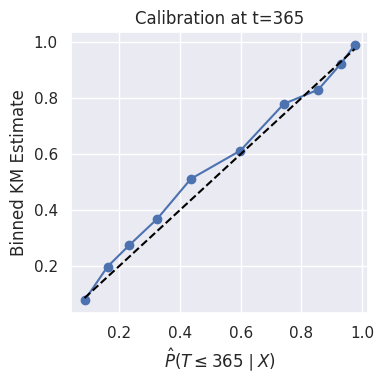

In [10]:
model.make_calibration_plot(X_test, y_test, eval_times=365)

It's clear from this plot that our trained model is well calibrated.